# Convolutional Neural Networks (CNNs)

The purpose of this notebook is to practice implementing and training CNNs. We start with a 1-dimensional convolutional layer in [NumPy](https://numpy.org/doc/).

We will then use [PyTorch](https://pytorch.org/), an optimised machine learning framework for Python based on the `torch` library to implement machine learning architectures.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# Importing losses, activation functions and layers from PyTorch
from torch.nn import Sequential, CrossEntropyLoss, Conv1d, MaxPool1d, Flatten, Linear, ReLU, Softmax, Parameter
from torch.utils.data import TensorDataset, DataLoader

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

You will be working with the [Human Activity Recognition (HAR) Using Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) dataset. This dataset captures movement data from a smartphone's built-in accelerometer and gyroscope while a person performs different activities. The six recorded activities are: walking on flat ground, walking upstairs, walking downstairs, sitting, standing, and lying down.

The smartphone records six measurements every 0.02 seconds: both linear acceleration and gyroscopic acceleration in the x, y, and z directions. Linear acceleration measures changes in speed without considering rotation, while gyroscopic acceleration tracks changes in orientation and angular velocity.

The goal is to use the accelerometer data to **predict the type of activity** (a multi-class classification task).

## 1. Loading and plotting the data

In [2]:
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')

x_val = np.load('x_val.npy')
y_val = np.load('y_val.npy')

x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

The input data consists of 6 features over 128 timesteps, and the output, which we are trying to predict, is a single integer from 0 to 5, which denotes the class.

There are 7352 examples in the training set, 2447 examples in the validation set and 500 in the test set. We can check the shapes ourselves.

In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(7352, 6, 128)
(7352, 1)
(2447, 6, 128)
(2447, 1)
(500, 6, 128)
(500, 1)


In [4]:
classes = [
    'Walking on flat ground',
    'Walking upstairs',
    'Walking downstairs',
    'Sitting',
    'Standing',
    'Laying'
]

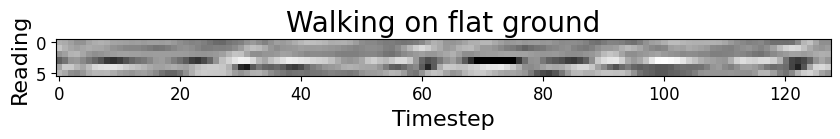

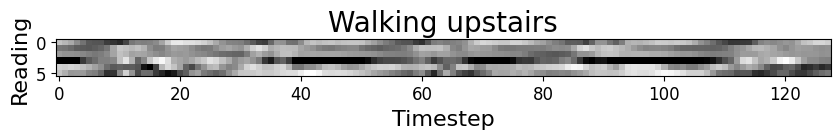

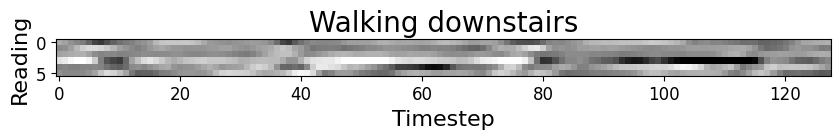

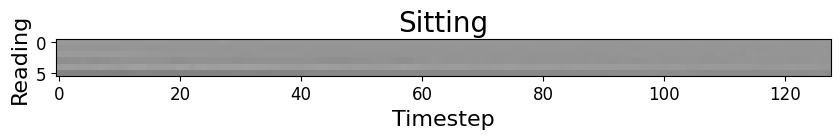

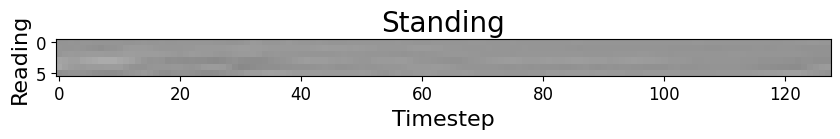

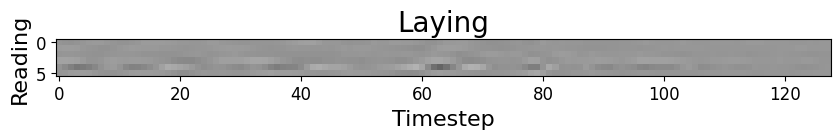

In [5]:
# Plot a randomly selected example from each class

for l, label in enumerate(range(len(classes))):
    inx = np.where(y_train[:, 0] == label)[0]
    i = np.random.choice(inx)
    x_example = x_train[i].T
    fig, ax = plt.subplots(figsize=(10, 1))
    ax.imshow(x_example.T, cmap='Greys', vmin=-1, vmax=1)
    ax.set_ylabel('Reading')
    ax.set_xlabel('Timestep')
    ax.set_title(classes[l])

## 2. 1D convolutional layer in NumPy

Now we will implement a 1D convolutional layer in `numpy`. The following function is designed to perform a 1D convolution on an input signal, given `weight` and `bias` parameters. The layer should have no `padding` and a `stride` of 1. The output should consist of the pre-activations of the layer, meaning that no activation function is then applied.

### Notation

* `c_in` and `c_out` (equal to `n_filters`) represent the number of input and output channels (respectively).
* `i` and `o` denote the length of the input and output signals (respectively).
* `k` is the length of the convolving kernel/filter.
* `p` is the total number of zero-padding pixels added to the input (padding).
* `s` is the number of pixels the kernel shifts per step (stride).

For a convolutional (or max pool) layer, the input and output lengths are related as follows:

$$o=\left\lfloor\frac{i+p-k}{s}\right\rfloor +1$$
(Note the use of the floor symbol, denoted as $\lfloor x\rfloor $, which represents the greatest integer less than or equal to a real number $x$).

In [6]:
## EDIT THIS FUNCTION
def conv1d(x, weight, bias):
    """
    Performs a 1D convolution over an input signal.

    Parameters:
        x (np.ndarray): Input signal of shape (batch_size, c_in, l_in) where c_in is the number of input channels and l_in is the length of the input signal.
        weight (np.ndarray): Learnable weights, shape (c_out, c_in, kernel_size) where c_out is the number of output channels and kernel_size is the size of the convolutional kernel.
        bias (np.ndarray): Bias parameters of size c_out

    Returns:
        An array of shape (batch_size, c_out, l_out) where l_out is the length of the output signal after convolution.

    """
    batch_size = x.shape[0] ## <-- SOLUTION
    l_in = x.shape[2] ## <-- SOLUTION
    c_out = weight.shape[0] ## <-- SOLUTION
    kernel_size = weight.shape[2] ## <-- SOLUTION

    l_out = l_in - kernel_size + 1 ## <-- SOLUTION
    outputs = np.zeros((batch_size, c_out, l_out))
    np.testing.assert_allclose(l_out, 113)

    for i in range(l_out):
        outputs[:, :, i] = (x[:, np.newaxis, :, i:i+kernel_size] * weight).sum(axis=(2, 3)) + bias ## <-- SOLUTION
        # the shape of x[:, np.newaxis, :, i:i+kernel_size] is (batch_size, 1, c_in, kernel_size)
        # the shape of weight is (c_out, c_in, kernel_size)
        # the multiplication broadcasts to (batch_size, c_out, c_in, kernel_size)
        # the sum over axes 2 and 3 gives us a shape of (batch_size, c_out)
        # adding the bias (which has shape (c_out,)) broadcasts correctly to (batch_size, c_out)
    return outputs

Now we can compare our layer with the PyTorch implementation.

In [7]:
# Test your layer
n_filters = 8
batch_size = 16
k = 16
i = 128

# PyTorch
conv_layer = Conv1d(x_train.shape[1], n_filters, k)
inputs = torch.randn((batch_size, x_train.shape[1], i))
y_torch = conv_layer(inputs)

# Our layer
y = conv1d(inputs.numpy(), conv_layer.weight.detach().numpy(), conv_layer.bias.detach().numpy())
np.allclose(y, y_torch.detach().numpy(), atol=1e-4)  ## <-- should be 'True'


True

### 3. Building a CNN in PyTorch

Before we can train a CNN model, we first need to build one using PyTorch. We will utilise the `Sequential` class to define the architecture and set up the necessary hyperparameters. The model will be designed to process the HAR dataset and will include the following layers:

* A `Conv1d` layer with 8 filters, kernel size of 16 and a `ReLU` activation function
  * The input shape should be `(6, 128)`
* A `MaxPoo1d` layer with a pooling window size of 16 and a stride of 2
* A `Flatten` layer
* A `Linear` layer with 6 neurons

The function below should build and compile this model, using an `Adam` optimiser and a `CrossEntropyLoss` criterion.

In [8]:
def get_model(x_train, n_filters, k, pool_size, stride_pool, classes):
    """
    CNN model in PyTorch:
    - Layers are Conv1d(+ReLU), MaxPool1d, Flatten and Linear(+Softmax).
    - It features an Adam optimiser and CrossEntropyLoss criterion.

    Parameters:
        x_train (np.ndarray): Training data
        n_filters (int): Number of filters to be used in the convolutional layer
        k (int): Kernel size in the convolutional layer
        pool_size (int): MaxPool1d window size
        stride_pool (int): Stride of the MaxPool1d sliding window
        classes (List): Output classes

    Returns:
        Model, criterion and optimiser.

    """

    l_out_conv = x_train.shape[2] - k + 1 # Length after Conv1d (note that the stride is 1) ## <-- SOLUTION
    l_out_pool = (l_out_conv - pool_size) // stride_pool + 1 # Length after MaxPool1d ## <-- SOLUTION
    l_in_linear = n_filters * l_out_pool # Size before Linear layer ## <-- SOLUTION
    np.testing.assert_allclose(l_in_linear, 392)

    model = Sequential(
        Conv1d(x_train.shape[1], n_filters, kernel_size=k),
        ReLU(), ## <-- SOLUTION
        MaxPool1d(kernel_size=pool_size, stride=stride_pool), ## <-- SOLUTION
        Flatten(), ## <-- SOLUTION
        Linear(l_in_linear, len(classes)), ## <-- SOLUTION
    )

    criterion = CrossEntropyLoss() ## <-- SOLUTION
    optimiser = torch.optim.Adam(model.parameters()) ## <-- SOLUTION

    return model, criterion, optimiser


In [9]:
# Run your function to get the model and print it

n_filters = 8
k = 16
pool_size = 16
stride_pool = 2

model, criterion, optimiser = get_model(x_train, n_filters, k, pool_size, stride_pool, classes) ## <-- SOLUTION
print(model)

Sequential(
  (0): Conv1d(6, 8, kernel_size=(16,), stride=(1,))
  (1): ReLU()
  (2): MaxPool1d(kernel_size=16, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=392, out_features=6, bias=True)
)


## 4. Training a CNN

Before training, we need to prepare our data. Since Deep Learning models in PyTorch operate on tensors, we first convert our NumPy arrays into tensors. These are then wrapped into `TensorDataset` objects, which help structure the data for training and validation. To efficiently load and iterate through batches of data, we use PyTorch's `DataLoader`.

Now we are ready to train the model. The `training_loop` function will handle the training process for a maximum of 200 epochs, with a batch size of 128. To ensure the model does not overfit and to prevent unnecessary training, we will implement early stopping based on validation accuracy. Specifically, the training will stop if the validation loss does not improve for 8 consecutive epochs (`max_patience=8`).

In [10]:
# Numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val)

# Creating training and validation datasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor.squeeze())
val_dataset = TensorDataset(x_val_tensor, y_val_tensor.squeeze())

# Creating corresponding DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [11]:
class EarlyStopping:
    """
    EarlyStopping class.

    Attributes:
        max_patience (int): Amount of epochs with no improvement after which training is stopped.
        patience (int): Stores the number of epochs with no improvement.
        best_valid_loss (float): Stores the current value of the best (minimum) validation loss.
        early_stop (bool) True if training needs to be stopped due to the early stopping condition being met.

    Methods:
        step(val_loss, model):  ## New model argument
            Checks current state after an epoch and updates best_loss, patience and early_stop accordingly.
    """

    def __init__(self, max_patience=5):
        self.max_patience = max_patience
        self.patience = 0
        self.best_valid_loss = float('inf') ## <-- SOLUTION
        self.early_stop = False
        self.best_model_state = None  ## New

    def step(self, val_loss, model):  ## New model argument
        if val_loss < self.best_valid_loss:  ## <-- SOLUTION
            self.best_valid_loss = val_loss  ## <-- SOLUTION
            self.patience = 0  ## <-- SOLUTION
            self.best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()} ## New
        else:
            self.patience += 1
            if self.patience >= self.max_patience:
                self.early_stop = True
    
    def load_best_weights(self, model):
        ## New
        if self.best_model_state is not None:
            model.load_state_dict(self.best_model_state)
            print("Loaded best model weights!")

In [12]:
def training_loop(train_loader, val_loader, max_num_epochs=200, max_patience=5):
    """
    Training loop with early stopping to monitor the validation accuracy.

    Parameters:
        train_loader (torch.utils.data.DataLoader): Training DataLoader
        val_loader (torch.utils.data.DataLoader): Validation DataLoader
        max_num_epochs (int): Maximum number of epochs
        max_patience (int): max_patience attribute of the EarlyStopping class

    Returns:
        Model, criterion and optimiser.

    """

    history = {'training_loss': [], 'validation_loss': [], 'training_accuracy': [], 'validation_accuracy': []}
    early_stopping = EarlyStopping(max_patience=max_patience)
    best_epoch = 0  # New

    for epoch in range(max_num_epochs):

        tr_loss = 0.0
        tr_correct = 0
        val_loss = 0.0
        val_correct = 0

        # Training
        model.train()
        for inputs, labels in train_loader:
            optimiser.zero_grad() # Setting gradients to zero
            outputs = model(inputs)
            loss = criterion(outputs, labels) ## <-- SOLUTION
            tr_loss += loss.item()
            tr_correct += (outputs.argmax(dim=1) == labels).sum().item() ## <-- SOLUTION
            loss.backward() # Computes gradients of the loss
            optimiser.step() # Optimisation step (parameters are updated)

        history['training_loss'].append(tr_loss/len(train_loader))
        history['training_accuracy'].append(100*tr_correct/len(train_dataset))

        # Validation
        model.eval()
        with torch.no_grad():
            for inputs_v, labels_v in val_loader:
                outputs_v = model(inputs_v)
                loss_v = criterion(outputs_v, labels_v) ## <-- SOLUTION
                val_loss += loss_v.item()
                if labels_v.size(0):
                    val_correct += (outputs_v.argmax(dim=1) == labels_v).sum().item() ## <-- SOLUTION

        history['validation_loss'].append(val_loss/len(val_loader))
        history['validation_accuracy'].append(100*val_correct/len(val_dataset))

        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch {epoch + 1}/{max_num_epochs}, Training loss: {tr_loss/len(train_loader)}, Training accuracy: {100*tr_correct/len(train_dataset)}%, Validation loss: {val_loss/len(val_loader)}, Validation accuracy: {100*val_correct/len(val_dataset)}%')

        # Check for early stopping
        early_stopping.step(val_loss / len(val_loader), model) ## New model argument

        if val_loss / len(val_loader) == early_stopping.best_valid_loss:
            # Record the epoch number of the best model
            best_epoch = epoch + 1

        if early_stopping.early_stop:
            print('Early stopping acting.')  ## <-- SOLUTION
            break  ## <-- SOLUTION

    early_stopping.load_best_weights(model)
    print(f"Best model was from Epoch {best_epoch}")

    return history, best_epoch

In [13]:
# Calling the training loop
max_num_epochs = 200
max_patience = 8

# Get the optimal number of epochs using early stopping on the validation set
model, criterion, optimiser = get_model(x_train, n_filters, k, pool_size, stride_pool, classes)
history, best_num_epochs = training_loop(train_loader, val_loader, max_num_epochs, max_patience)

Epoch 1/200, Training loss: 1.516228955367516, Training accuracy: 28.794885745375407%, Validation loss: 1.3669462621212005, Validation accuracy: 50.55169595422967%
Epoch 10/200, Training loss: 0.584847621876618, Training accuracy: 67.77747551686616%, Validation loss: 0.6464452415704727, Validation accuracy: 66.77564364527993%
Epoch 20/200, Training loss: 0.48141750641937914, Training accuracy: 80.97116430903155%, Validation loss: 0.602783291041851, Validation accuracy: 77.52349816101349%
Epoch 30/200, Training loss: 0.4052979422026667, Training accuracy: 85.2285092491839%, Validation loss: 0.5553039327263832, Validation accuracy: 83.12219043727012%
Epoch 40/200, Training loss: 0.36000102039041193, Training accuracy: 87.70402611534277%, Validation loss: 0.533164881169796, Validation accuracy: 84.51164691458929%
Early stopping acting.
Loaded best model weights!
Best model was from Epoch 37


We visualise loss and accuracy over epochs to assess the model's learning progress, helping us evaluate its convergence and generalisation.

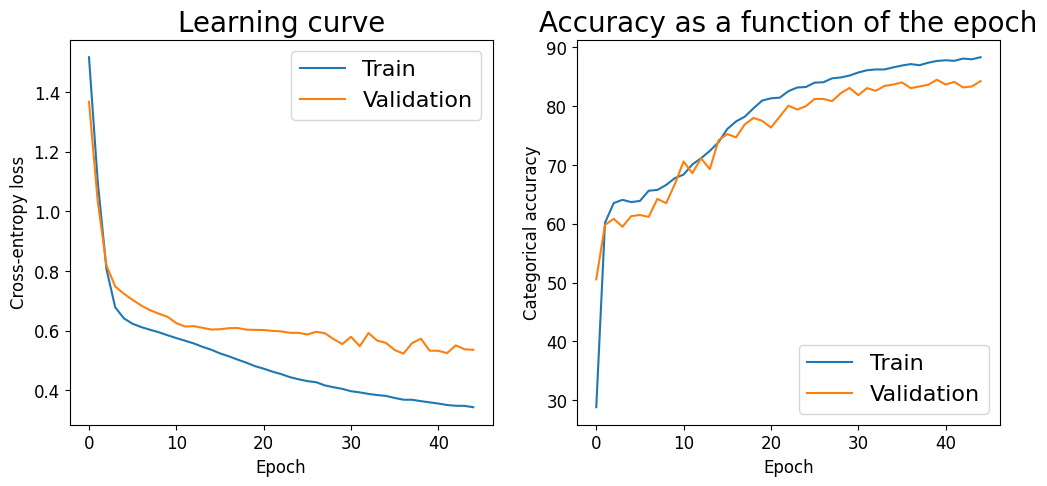

In [14]:
# Plot the learning curves

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(history['training_loss'], label='Train')
plt.plot(history['validation_loss'], label='Validation')
plt.xlabel('Epoch', size=12)
plt.ylabel('Cross-entropy loss', size=12)
plt.title('Learning curve')
plt.legend()

fig.add_subplot(122)
plt.plot(history['training_accuracy'], label='Train')
plt.plot(history['validation_accuracy'], label='Validation')
plt.xlabel('Epoch', size=12)
plt.ylabel('Categorical accuracy', size=12)
plt.title('Accuracy as a function of the epoch')
plt.legend()

plt.show()

Next, we retrain the model with the optimal number of epochs on the full training set.

In [15]:
# 1. Concatenate training and validation sets to create a full dataset for training
x_full = np.concatenate((x_train, x_val))
y_full = np.concatenate((y_train, y_val))

# 2. Create a full DataLoader
full_dataset = TensorDataset(torch.tensor(x_full, dtype=torch.float32), torch.tensor(y_full).squeeze())
full_loader = DataLoader(full_dataset, batch_size=128, shuffle=True)

# 3. Re-initialize a brand new model
model, criterion, optimiser = get_model(x_full, n_filters, k, pool_size, stride_pool, classes)

# 4. Train for a fixed number of best_num_epochs without validation and early stopping
model.train()
for epoch in range(best_num_epochs):
    tr_loss = 0.0
    tr_correct = 0
    for inputs, labels in full_loader:
        optimiser.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        tr_correct += (outputs.argmax(dim=1) == labels).sum().item()
        loss.backward()
        optimiser.step()
        tr_loss += loss.item()
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Retrain Epoch {epoch+1}/{best_num_epochs}, Loss: {tr_loss/len(full_loader):.4f}, Accuracy: {100*tr_correct/len(full_dataset):.2f}%")

Retrain Epoch 1/37, Loss: 1.4328, Accuracy: 37.91%
Retrain Epoch 10/37, Loss: 0.5358, Accuracy: 73.84%
Retrain Epoch 20/37, Loss: 0.4690, Accuracy: 81.18%
Retrain Epoch 30/37, Loss: 0.4093, Accuracy: 84.84%


Both loss and accuracy improve over time, but the gap between training and validation suggests a slight overfitting.

## 5. Evaluating the test performance of a CNN

Now let's take a look at some model predictions!

In [16]:
# Get the model probabilities
preds = torch.softmax(model(torch.tensor(x_test, dtype=torch.float32)), dim=1).detach().numpy()  ## <-- SOLUTION

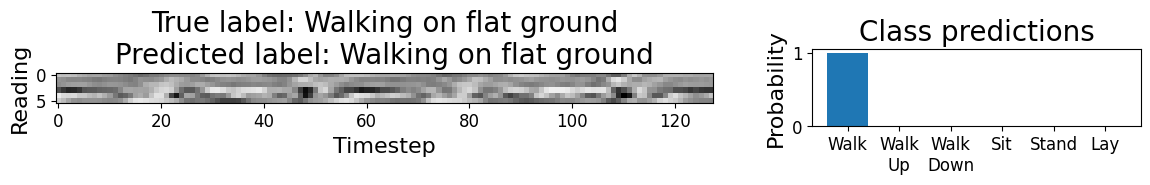

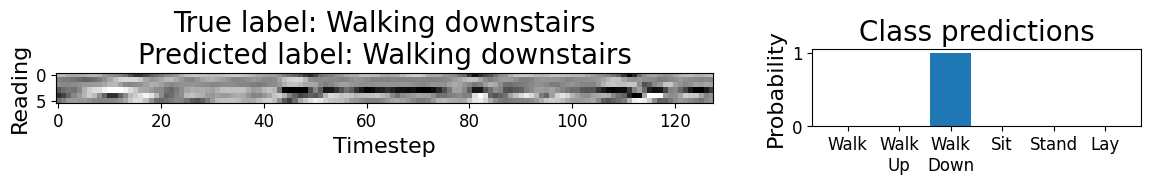

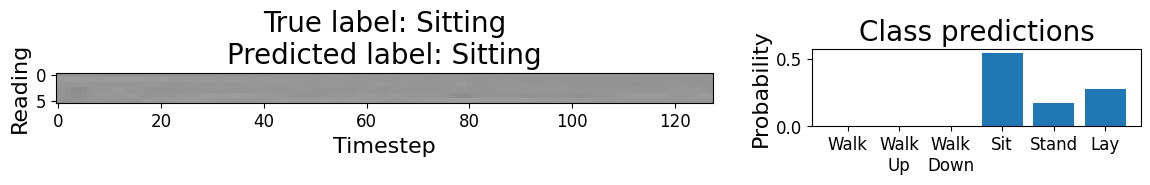

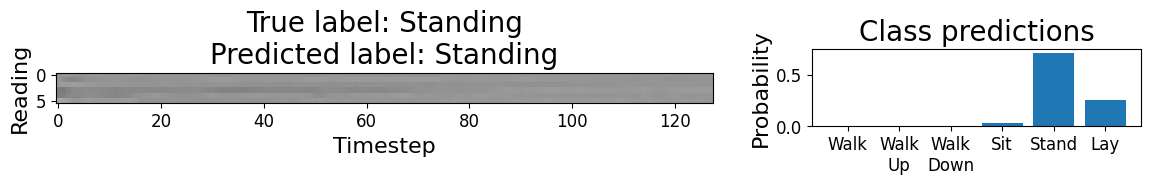

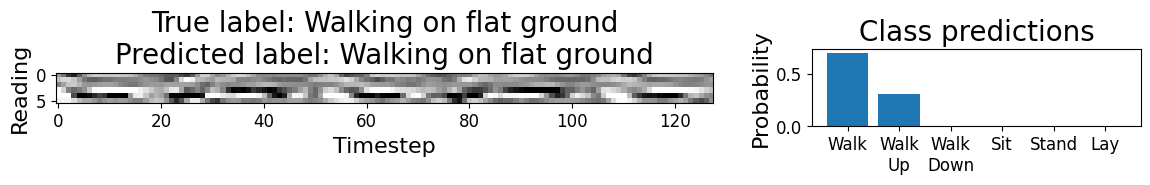

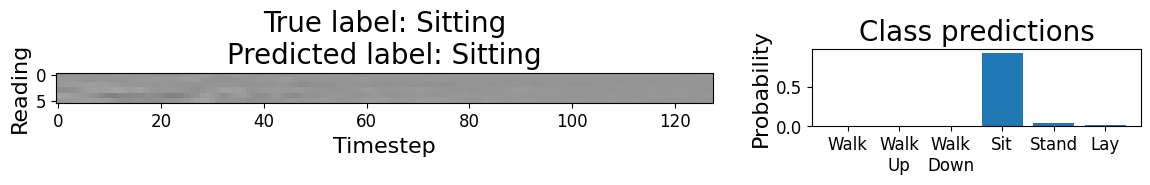

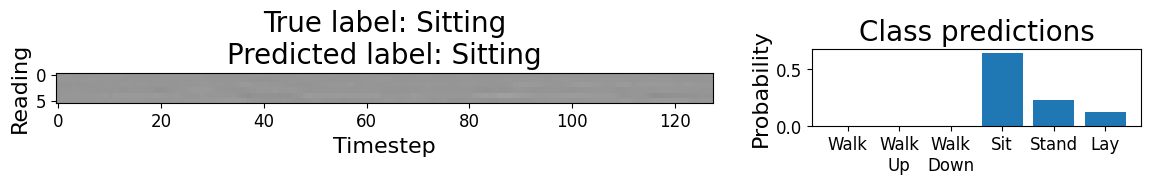

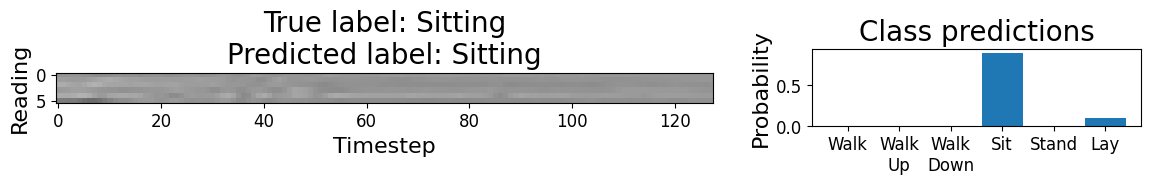

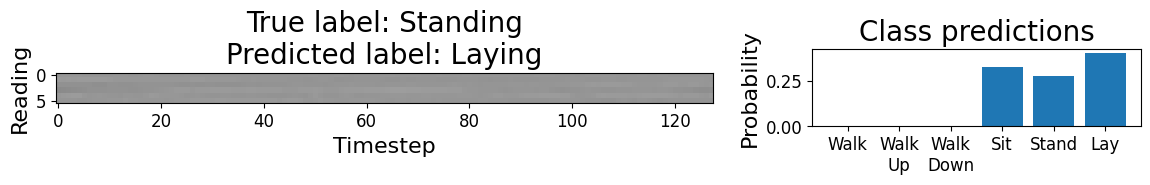

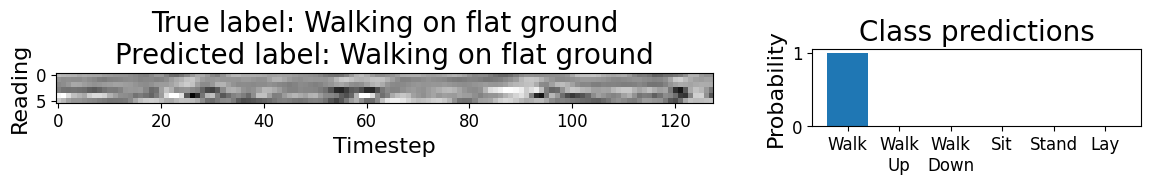

In [17]:
# Plot some example predictions

num_preds = preds.shape[0]
num_examples = 10
inx = np.random.choice(num_preds, num_examples, replace=False)
gs = {'width_ratios': [2, 1]}

for i in inx:
    x_example = x_test[i]
    true_label = y_test[i][0]
    prediction = preds[i]
    pred_class = np.argmax(prediction)
    fig, ax = plt.subplots(figsize=(14, 1), ncols=2, gridspec_kw=gs)
    ax[0].imshow(x_example, cmap='Greys', vmin=-1, vmax=1)
    ax[0].set_ylabel('Reading')
    ax[0].set_xlabel('Timestep')
    ax[0].set_title('True label: {}\nPredicted label: {}'.format(classes[true_label], classes[pred_class]))
    ax[1].bar(['Walk', 'Walk\nUp', 'Walk\nDown', 'Sit', 'Stand', 'Lay'], prediction)
    ax[1].set_title('Class predictions')
    ax[1].set_ylabel('Probability')

### Questions
1. Why have we not explicitly added a `Softmax` layer after the final linear layer of the CNN?
2. Are there particular classes where the model tends to be more uncertain in its predictions?
3. What effect does weight regularisation have on training and the final model? Apply regularisation to your model and experiment with different values of the regularisation coefficient to observe its impact.
4. How did the `max_patience` hyperparameter impact the training run above? What would have happened if we set `max_patience` to zero?
5. How does the training change when using the `SGD` optimiser instead of `Adam`?

### Answer to question 1

Let the model output be a vector of logits:

$$\mathbf{a} = [a_1, a_2, \dots, a_Q],$$

where $Q$ is the number of classes.

`Softmax` converts logits into probabilities:

$$P(y = c \mid \mathbf{a}) = \frac{\exp(a_c)}{\sum_{q=1}^{Q}\exp(a_q)}.$$

However, we do not explicitly add a `Softmax` layer after the final linear layer in the CNN because PyTorch's `CrossEntropyLoss` already combines `Softmax` and Negative Log-Likelihood loss (`NLLLoss`). It directly applies `log_softmax`, which is mathematically equivalent but numerically more stable:

$$\log P(y = c \mid \mathbf{a}) = a_c - \log \sum_{q=1}^{Q} \exp(a_q).$$

The `CrossEntropyLoss` then computes the loss for a mini-batch of size $|S_m|$:

$$L = -\frac{1}{|S_m|} \sum_{i\in S_m}\log P(y^{(i)} \mid \mathbf{a}^{(i)}) = - \frac{1}{|S_m|} \sum_{i\in S_m}\left(a^{(i)}_{y_i} - \log \sum_{q=1}^{Q} \exp(a^{(i)}_{q}) \right),$$

where $a^{(i)}_{y_i}$ represents the logit (raw score) corresponding to the correct class $y^{(i)}$ for the $i$-th sample in the batch.